Libraries and Dependencies

In [1]:
import MyPipe as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import FunctionTransformer

c:\Users\adriano.minora\Desktop\xtream-ai-assignment-developer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Function and class definition

In [2]:
class xgbReg():
    def __init__(self, enable_categorical=True, random_state=42):
        self.xgb = xgboost.XGBRegressor(enable_categorical=enable_categorical, random_state=random_state)
    
    def fit(self, x, y):
        self.xgb.fit(x, y)
    
    def predict(self, x):
        return self.xgb.predict(x)
    
class optParam:
    def __init__(self, objective, enable_categorical=True, random_state=42, direction='minimize', study_name='my_study', n_trials=100):
        self.study = optuna.create_study(direction=direction, study_name=study_name)
        self.objective = objective
        self.n_trials = n_trials
        self.xgb_opt = None
        self.enable_categorical = enable_categorical
        self.random_state = random_state
    
    def fit(self, x, y):
        self.study.optimize(self.objective, n_trials=self.n_trials)
        self.xgb_opt = xgboost.XGBRegressor(**self.study.best_params, enable_categorical=self.enable_categorical, random_state=self.random_state)
        self.xgb_opt.fit(x, y)

    def predict(self, x):
        return self.xgb_opt.predict(x)


def preprocess_data(raw_data: pd.DataFrame):
    raw_data = raw_data[(raw_data.x * raw_data.y * raw_data.z != 0) & (raw_data.price > 0)] # Clean zero dimensions and negative prices
    processed_data = raw_data.copy()
    processed_data['cut'] = pd.Categorical(processed_data['cut'], categories=['Fair', 'Good', 'Very Good', 'Ideal', 'Premium'], ordered=True)
    processed_data['color'] = pd.Categorical(processed_data['color'], categories=['D', 'E', 'F', 'G', 'H', 'I', 'J'], ordered=True)
    processed_data['clarity'] = pd.Categorical(processed_data['clarity'], categories=['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'], ordered=True)
    return processed_data

def split_data(data: pd.DataFrame, test_size=0.2, random_state=42, apply_ylog = False):
    x = data.drop(columns='price')
    y = data['price']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    if (apply_ylog):
        y_train = np.log(y_train)
        y_test = np.log(y_test)
    return x_train, x_test, y_train, y_test


    
def plot_gof(y_true: pd.Series, y_pred: pd.Series):
    plt.plot(y_true, y_pred, '.')
    plt.plot(y_true, y_true, linewidth=3, c='black')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()


C2.1 Example on how to use the class MyPipe with the whole dataset (no data acquisition) and the custom trasformer xgbReg

In [3]:
diamonds = pd.read_csv("https://raw.githubusercontent.com/xtreamsrl/xtream-ai-assignment-engineer/main/datasets/diamonds/diamonds.csv")

data = preprocess_data(diamonds)
x_train, x_test, y_train, y_test = split_data(data)

my_steps = [('regression', xgbReg())]

In [4]:
my_pipeline = mp.MyPipe(steps=my_steps)
my_pipeline.define_data(data)
my_pipeline.fit(x_train,y_train)

pred = my_pipeline.predict(x_test)
performance = my_pipeline.evaluate_performance(y_test,pred)

In [5]:
performance

{'r2': np.float64(0.9593), 'MAE': np.float64(354.95)}

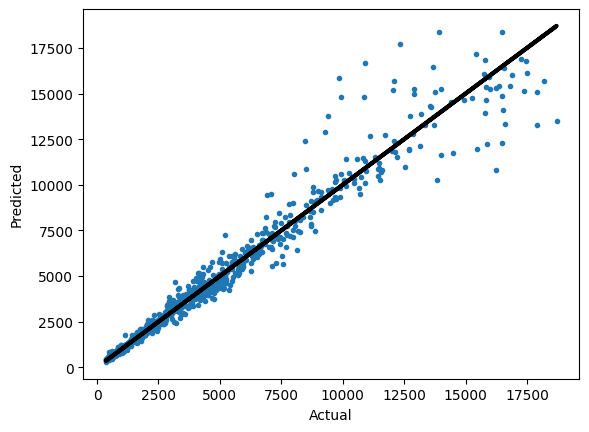

In [6]:
plot_gof(y_test, pred)

C2.2 Example on how to include the optuna improvement

In [7]:
#Define the objective function
def objective(trial: optuna.trial.Trial) -> float:
    # Define hyperparameters to tune
    param = {
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.7]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'enable_categorical': True
    }

    # Split the training data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train_opt, y_train_opt, test_size=0.2, random_state=42)

    # Train the model
    model = xgboost.XGBRegressor(**param)
    model.fit(x_train, y_train)

    # Make predictions
    preds = model.predict(x_val)

    # Calculate MAE
    mae = mean_absolute_error(y_val, preds)

    return mae

In [8]:
x_train_opt, x_test_opt, y_train_opt, y_test_opt = split_data(data)

my_steps = [('parameters optimization', optParam(objective, n_trials=100))]

[I 2024-07-03 15:45:52,494] A new study created in memory with name: my_study


In [9]:
my_pipeline = mp.MyPipe(steps=my_steps)
my_pipeline.define_data(data)
my_pipeline.fit(x_train_opt,y_train_opt)

pred_opt = my_pipeline.predict(x_test_opt)
performance = my_pipeline.evaluate_performance(y_test_opt,pred_opt)

[I 2024-07-03 15:45:57,411] Trial 0 finished with value: 402.9393685618987 and parameters: {'lambda': 0.048698516515795626, 'alpha': 7.787733960052321e-05, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.0051472363677328185, 'n_estimators': 853, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 0 with value: 402.9393685618987.
[I 2024-07-03 15:45:58,713] Trial 1 finished with value: 317.7141715611922 and parameters: {'lambda': 3.0571681817783265e-06, 'alpha': 8.984659943883867e-05, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.017715087852915205, 'n_estimators': 719, 'max_depth': 5, 'min_child_weight': 9}. Best is trial 1 with value: 317.7141715611922.
[I 2024-07-03 15:46:01,119] Trial 2 finished with value: 2884.9475314602237 and parameters: {'lambda': 0.0022855937654496223, 'alpha': 5.8030202686377514e-05, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 2.940775782566473e-07, 'n_estimators': 912, 'max_depth': 6, 'min_child_weight': 5}. Be

C2.3 Simulate data acquisition

In [10]:
half = int(len(data.index)/2)
data0 = data[:half] # Suppose we know half of the data at the beginning of the procedure
batch_size = 300 #Number of new diamonds in each batch of new data
data_new = [] # List of the data coming in batch at every update
i = 0
while (half+batch_size*(i+1)<len(data.index)):
    data_new.append(data[half+batch_size*i:half+batch_size*(i+1)])
    i +=1
data_new.append(data[half+batch_size*i:])

model_history = [] # for mantaining a track of each trained model

# Define the first model with half of the data
x_train, x_test, y_train, y_test = split_data(data0, apply_ylog=False)

my_steps = [('parameters optimization', optParam(objective, n_trials=20))]

my_pipeline = mp.MyPipe(steps=my_steps)
my_pipeline.define_data(data0)
my_pipeline.fit(x_train,y_train)

pred = my_pipeline.predict(x_test)
performance = my_pipeline.evaluate_performance(y_test, pred)

for n, current_data in enumerate(data_new):
    print(f'Batch {n+1} of {len(data_new)}')
    my_pipeline.augment_data(current_data)
    x_train, x_test, y_train, y_test = split_data(my_pipeline.data, apply_ylog=False)
    my_pipeline.fit(x_train, y_train)
    pred = my_pipeline.predict(x_test)
    performance = my_pipeline.evaluate_performance(y_test, pred)
    model_params = my_pipeline.pipe.steps[0][1].study.best_params
    model_history.append(model_params)

[I 2024-07-03 15:48:17,923] A new study created in memory with name: my_study


[I 2024-07-03 15:48:19,703] Trial 0 finished with value: 521.0073327648178 and parameters: {'lambda': 2.1271353604480933e-08, 'alpha': 0.0003397788752779941, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.5292774479993331, 'n_estimators': 850, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 0 with value: 521.0073327648178.
[I 2024-07-03 15:48:20,500] Trial 1 finished with value: 773.8474875821339 and parameters: {'lambda': 0.6248771635432449, 'alpha': 3.2837654758933586e-05, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01456412962207497, 'n_estimators': 105, 'max_depth': 7, 'min_child_weight': 2}. Best is trial 0 with value: 521.0073327648178.
[I 2024-07-03 15:48:22,541] Trial 2 finished with value: 2885.4876267453456 and parameters: {'lambda': 1.746661011209356e-06, 'alpha': 7.766259833626166e-05, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 8.785130797652534e-08, 'n_estimators': 743, 'max_depth': 5, 'min_child_weight': 10}. Best is

Batch 1 of 9


[I 2024-07-03 15:48:39,653] Trial 20 finished with value: 2848.92929608055 and parameters: {'lambda': 0.03145894694346123, 'alpha': 1.6259265368674234e-06, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 5.699637858458582e-05, 'n_estimators': 243, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 19 with value: 327.7892919356593.
[I 2024-07-03 15:48:40,217] Trial 21 finished with value: 328.3469721826355 and parameters: {'lambda': 0.0003003913977485278, 'alpha': 5.718860675566321e-08, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.025434213227623133, 'n_estimators': 305, 'max_depth': 5, 'min_child_weight': 3}. Best is trial 19 with value: 327.7892919356593.
[I 2024-07-03 15:48:40,692] Trial 22 finished with value: 333.4022996732977 and parameters: {'lambda': 0.039954409437347856, 'alpha': 4.744061073866413e-07, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.06905089046752529, 'n_estimators': 302, 'max_depth': 5, 'min_child_weight': 3}. Best

Batch 2 of 9


[I 2024-07-03 15:48:49,947] Trial 40 finished with value: 1088.7320154832212 and parameters: {'lambda': 0.17598539946608258, 'alpha': 2.1718006518951477e-07, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.00997049668731985, 'n_estimators': 111, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 33 with value: 304.3470394817252.
[I 2024-07-03 15:48:50,232] Trial 41 finished with value: 299.28285811212993 and parameters: {'lambda': 0.8894623332362848, 'alpha': 6.267831538188718e-08, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.16921437905285044, 'n_estimators': 146, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 41 with value: 299.28285811212993.
[I 2024-07-03 15:48:50,536] Trial 42 finished with value: 315.425926122558 and parameters: {'lambda': 0.7663519302233535, 'alpha': 1.1710755647690125e-06, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.13082879015173257, 'n_estimators': 150, 'max_depth': 4, 'min_child_weight': 2}. Best is 

Batch 3 of 9


[I 2024-07-03 15:49:05,613] Trial 60 finished with value: 2173.948957498142 and parameters: {'lambda': 0.0001478977882005237, 'alpha': 8.453595540383241e-08, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.0005166889765062624, 'n_estimators': 570, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 56 with value: 295.47165367689837.
[I 2024-07-03 15:49:08,066] Trial 61 finished with value: 299.23875352766396 and parameters: {'lambda': 0.0010068942993206765, 'alpha': 4.083208635819943e-07, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.017745706947186926, 'n_estimators': 638, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 56 with value: 295.47165367689837.
[I 2024-07-03 15:49:09,873] Trial 62 finished with value: 301.4112977372839 and parameters: {'lambda': 0.0009644930534295788, 'alpha': 4.5109180958198585e-07, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.016320668432644812, 'n_estimators': 657, 'max_depth': 6, 'min_child_weight': 

Batch 4 of 9


[I 2024-07-03 15:50:04,495] Trial 80 finished with value: 294.4809154372042 and parameters: {'lambda': 0.01455319538462736, 'alpha': 2.1110211980979453e-07, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.03408648273166939, 'n_estimators': 621, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 80 with value: 294.4809154372042.
[I 2024-07-03 15:50:05,541] Trial 81 finished with value: 290.84627169154317 and parameters: {'lambda': 0.011127890739599843, 'alpha': 2.3242243741641231e-07, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.02969140183822859, 'n_estimators': 616, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 81 with value: 290.84627169154317.
[I 2024-07-03 15:50:06,600] Trial 82 finished with value: 300.78922161918706 and parameters: {'lambda': 0.014366180201615808, 'alpha': 2.123955264528365e-07, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.06428682363824219, 'n_estimators': 621, 'max_depth': 5, 'min_child_weight': 1}. Bes

Batch 5 of 9


[I 2024-07-03 15:50:25,941] Trial 100 finished with value: 297.54103307998525 and parameters: {'lambda': 6.10034031698435e-07, 'alpha': 9.868532630415528e-08, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.02518313469939874, 'n_estimators': 492, 'max_depth': 5, 'min_child_weight': 3}. Best is trial 81 with value: 290.84627169154317.
[I 2024-07-03 15:50:27,106] Trial 101 finished with value: 304.8399097122746 and parameters: {'lambda': 1.2646220840930268e-07, 'alpha': 1.4664504992217212e-08, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.09775192585446668, 'n_estimators': 516, 'max_depth': 5, 'min_child_weight': 3}. Best is trial 81 with value: 290.84627169154317.
[I 2024-07-03 15:50:28,705] Trial 102 finished with value: 2823.2226195830726 and parameters: {'lambda': 2.216892057141059e-06, 'alpha': 4.144308143514357e-08, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 4.132115254184034e-05, 'n_estimators': 549, 'max_depth': 5, 'min_child_weight'

Batch 6 of 9


[I 2024-07-03 15:50:52,641] Trial 120 finished with value: 309.60752912576265 and parameters: {'lambda': 1.0072088928746281e-08, 'alpha': 1.2916086379626141e-06, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.0303671309046068, 'n_estimators': 636, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 81 with value: 290.84627169154317.
[I 2024-07-03 15:50:54,260] Trial 121 finished with value: 299.5032581238633 and parameters: {'lambda': 0.009048620868240594, 'alpha': 1.3235868530930032e-07, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.017768232943423664, 'n_estimators': 668, 'max_depth': 5, 'min_child_weight': 3}. Best is trial 81 with value: 290.84627169154317.
[I 2024-07-03 15:50:55,985] Trial 122 finished with value: 303.5733973726313 and parameters: {'lambda': 6.847957887199643e-08, 'alpha': 1.994907172832876e-07, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.011278545125159054, 'n_estimators': 627, 'max_depth': 5, 'min_child_weight':

Batch 7 of 9


[I 2024-07-03 15:51:16,040] Trial 140 finished with value: 316.2273548493845 and parameters: {'lambda': 0.44637436054484947, 'alpha': 0.0025547910146464245, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.009878400944095131, 'n_estimators': 472, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 135 with value: 289.6135786340592.
[I 2024-07-03 15:51:17,107] Trial 141 finished with value: 295.2740938380006 and parameters: {'lambda': 0.015773335533670097, 'alpha': 0.011728051655291671, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.024242769581977613, 'n_estimators': 432, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 135 with value: 289.6135786340592.
[I 2024-07-03 15:51:17,901] Trial 142 finished with value: 291.763301424449 and parameters: {'lambda': 0.01596394852028971, 'alpha': 0.0014352541539349327, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.025850483411996503, 'n_estimators': 434, 'max_depth': 5, 'min_child_weight': 2}. Bes

Batch 8 of 9


[I 2024-07-03 15:51:39,957] Trial 160 finished with value: 325.7733676036696 and parameters: {'lambda': 0.014964823563703085, 'alpha': 0.0006065080240503506, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02703690103453104, 'n_estimators': 391, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 145 with value: 288.7299392566514.
[I 2024-07-03 15:51:40,962] Trial 161 finished with value: 296.4944554258497 and parameters: {'lambda': 8.209865771153535e-06, 'alpha': 0.001218629655811557, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.032722110805736435, 'n_estimators': 412, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 145 with value: 288.7299392566514.
[I 2024-07-03 15:51:41,774] Trial 162 finished with value: 302.56814315471246 and parameters: {'lambda': 0.029392379318859067, 'alpha': 0.03559198637267747, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.06472097243560403, 'n_estimators': 337, 'max_depth': 5, 'min_child_weight': 2}. Be

Batch 9 of 9


[I 2024-07-03 15:52:02,709] Trial 180 finished with value: 298.86833200466646 and parameters: {'lambda': 0.048674175483005705, 'alpha': 0.0020210558875155766, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.07843334358098629, 'n_estimators': 428, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 145 with value: 288.7299392566514.
[I 2024-07-03 15:52:03,623] Trial 181 finished with value: 294.07795805089614 and parameters: {'lambda': 0.07638373374796584, 'alpha': 0.0010003192202617621, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.0348274396147989, 'n_estimators': 388, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 145 with value: 288.7299392566514.
[I 2024-07-03 15:52:04,659] Trial 182 finished with value: 293.47875254682367 and parameters: {'lambda': 0.2952810995857024, 'alpha': 0.0005005741531835571, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.029860500783862712, 'n_estimators': 408, 'max_depth': 5, 'min_child_weight': 2}. Be

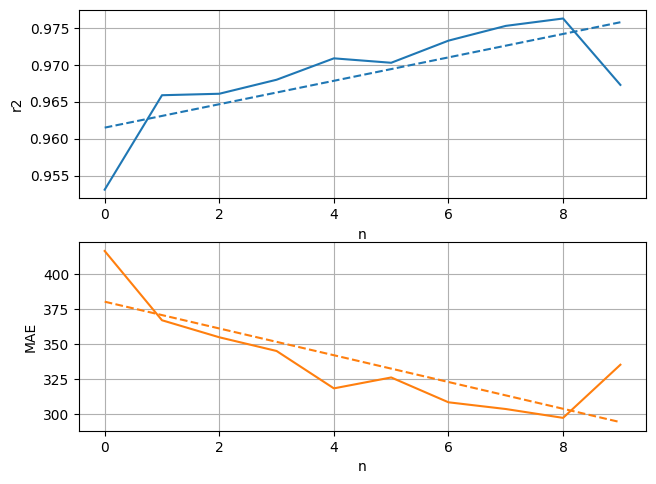

In [11]:
my_pipeline.plot_history(trendline=True)